# Generation of Heterogenous Dataset for Federated Learning for Molecular Property Prediction

NOTE: Please do not edit the code cells! Colab doesn't handle multi-user real time collaboration very well. However, please feel free to leave as many comments as you wish!

## Installation

In [ ]:
# Install Rdkit, OGB and DGL/DGL Life for datasets
# You may need to restart the runtime
!pip3 install rdkit
!pip3 install dgl
!pip3 install dgllife
!pip3 install ogb

In [ ]:
# Install torch_geometric
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip3 install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip3 install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip3 install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
# turn on debugger
!pip install -Uqq ipdb
import ipdb
%pdb on

In [ ]:
%pdb off

Automatic pdb calling has been turned OFF


## Downloading datasets

The code section below is heavily adapted from the FedChem paper at https://github.com/ur-whitelab/fedchem/blob/main/downloadDataset.py

In [ ]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

import dgl
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer
from dgllife.data import BACE, BBBP, ClinTox, ESOL, Lipophilicity, FreeSolv, SIDER, Tox21
from ogb.lsc import PCQM4Mv2Dataset
from torch_geometric.datasets import QM9

def getDataset(datasetName, load_prev=True):
    if datasetName == "PCQM4Mv2":
        dataset = PCQM4Mv2Dataset(only_smiles = True)

    elif datasetName in ['BACE', 'BBBP', 'ClinTox', 'Esol', 'Freesolv',
                         'Lipophilicity', 'SIDER', 'Tox21', 'qm9']:

        node_featurizer = CanonicalAtomFeaturizer()

        if datasetName == 'BACE':  
            dataset = BACE(smiles_to_bigraph, node_featurizer, load=load_prev)
        elif datasetName == 'BBBP':  
            dataset = BBBP(smiles_to_bigraph, node_featurizer, load=load_prev)
        elif datasetName == 'ClinTox':  
            dataset = ClinTox(smiles_to_bigraph, node_featurizer, load=load_prev)
        elif datasetName == 'Esol':
            dataset = ESOL(smiles_to_bigraph, node_featurizer, load=load_prev)
        elif datasetName == 'Freesolv':
            dataset = FreeSolv(smiles_to_bigraph, node_featurizer, load=load_prev)
        elif datasetName == 'Lipophilicity':
            dataset = Lipophilicity(smiles_to_bigraph, node_featurizer, load=load_prev)
        elif datasetName == 'SIDER':  
            dataset = SIDER(smiles_to_bigraph, node_featurizer, load=load_prev)
        elif datasetName == 'Tox21':  
            dataset = Tox21(smiles_to_bigraph, node_featurizer, load=load_prev)
    else:
        raise ValueError(f'Unexpected dataset: {datasetName}')

    return dataset

for i in ['BACE', 'BBBP', 'ClinTox', 'Esol', 'Freesolv', 'Lipophilicity', 'SIDER', 'Tox21', 'PCQM4Mv2']:
    print("start to download "+i)
    getDataset(i, load_prev=False)
    print(i+" finished ")

## Molecular Fingerprinting

In the field of drug discovery, pharmaceutical companies would specialise into different chemical domains to achieve a competitive advantage over other companies. Similarly, in an academic setting, research institutions would have a heterogeneous distribution of experts in different chemical fields, and hence their privately held data would not be drawn independently and individually across the global chemical space. Thus, in our setting of Federated Learning, it is realistic to assume that private datasets owned by the organisations have hetereogenous distributions. 

This problem is also acknowledged by FedChem, and their method involves splitting molecules by scaffold splitting. Scaffold splitting sorts molecules by their backbone structure such that molecules that share a similar structural backbone are grouped together. This is possible in a pharmaceutical/drug discovery setting since molecules are usually synthesised from a base molecule (which is the chemical backbone itself); however, some datasets in FedChem are not related to drug discovery, thus scaffold splitting is inappropriately used. Instead, cheminformatics (the field of chemistry and information science) uses [molecular fingerprints](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3) to classify molecules. These fingerprints are based on functional groups or short substructures that are present in molecules, and are more widely applicable than scaffold splitting. As a result, we split molecules into groups based on the Tanimoto similarity between [ECFP4 fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t). 

In [4]:
# See http://www.dalkescientific.com/writings/diary/archive/2020/10/02/using_rdkit_bulktanimotosimilarity.html
# https://github.com/deepchem/deepchem/blob/master/deepchem/splits/splitters.py#L1220-L1287

from rdkit import Chem
from rdkit.Chem import AllChem

def get_fingerprints(smiles_list, nBits=1024):
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    return [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits) for x in mol_list]


## Clustering using Latent Dirichlet Allocation (LDA)

With the vectorised representations of molecules, LDA can be used as an unsupervised learning method to fit the molecules into X different groups, where X would be the number of organisations for Federated Learning in our problem statement. As stated in FedChem, the heterogeneity of datasets can be controlled by tuning the $\alpha$ parameter in LDA, and we use it similarly. 

For more information on how the $\alpha$ parameter changes the behaviour of LDA, see https://stats.stackexchange.com/questions/244917/what-exactly-is-the-alpha-in-the-dirichlet-distribution

In [5]:
from sklearn.decomposition import LatentDirichletAllocation

def split_data_LDA(vectors, num_grps, alpha, min_size=128):
    """
    Clusters vectors using Latent Dirichlet Allocation
    args:
        vectors:      List of fingerprint representation of molecules
        num_grps:     Number of clusters
        alpha:        (0,1]. Controls heterogeneity of dataset, lower values being more distinct
    return:
        cluster_idx:  N numpy array. Index of cluster for each row in vector
    """
    
    lda = LatentDirichletAllocation(n_components=num_grps, doc_topic_prior=alpha,
                                    learning_method="online", random_state=0)
    lda.fit(vectors)

    # Gives prob of each fingerprint in FPS belonging to the organisation
    group_logits = lda.transform(vectors)

    cluster_idx = np.argmax(group_logits, axis=1)

    net_dataidx_map = {}
    idxs = np.arange(len(vectors))
    sizes = []
    for i in range(num_grps):
        net_dataidx_map[i] = idxs[cluster_idx == i]
        np.random.shuffle(net_dataidx_map[i])
        net_dataidx_map[i] = net_dataidx_map[i].tolist()
        sizes.append((len(net_dataidx_map[i]), i))

    sizes.sort()

    if sizes[0][1] >= min_size:
        return net_dataidx_map

    net_dataidx_map = {}
    used_idxs = set()
    for curr_s in range(len(sizes)):
        idx_to_query = sizes[curr_s][1]
        if curr_s == len(sizes)-1:
            net_dataidx_map[idx_to_query] = list(set(range(len(vectors))).difference(used_idxs))
        else:
            indexes = idxs[cluster_idx == idx_to_query]
            remaining_indexes = list(set(indexes.tolist()).difference(used_idxs))
            if len(remaining_indexes) >= min_size:
                net_dataidx_map[idx_to_query] = remaining_indexes
            else:
                logit = group_logits[:, idx_to_query]
                all_idx_args = np.argsort(logit).tolist()
                net_dataidx_map[idx_to_query] = []
                temp = 0
                while len(net_dataidx_map[idx_to_query]) < min_size:
                    idx = all_idx_args[temp]
                    if idx not in used_idxs:
                        net_dataidx_map[idx_to_query].append(idx)
                    temp += 1

        used_idxs = used_idxs.union(set(net_dataidx_map[idx_to_query]))
        
    return net_dataidx_map

## Scaffold Clustering

An analogy of scaffolds is something like roots of words. A scaffold of a molecule is the base structure without modifications, usually in the form of a carbon structure. Thus, similar molecules are grouped together by the basis of their molecular structure. However, this is applicable mainly to drug-like molecules, and is less effective for small molecules. 

In [6]:
from rdkit import Chem

def scaffold_clustering(smiles_list):
    d = {}
    cluster_id = 0
    ans = []
    for idx, smiles in enumerate(smiles_list):
        scaffold = Chem.Scaffolds.MurckoScaffold.MurckoScaffoldSmilesFromSmiles(smiles)
        if scaffold not in d:
            d[scaffold] = cluster_id
            cluster_id += 1
        ans.append(d[scaffold])
    return np.asarray(ans)

## Splitting

In [7]:
# The code below is modified from the following repo:
# https://github.com/FedML-AI/FedML/blob/master/python/fedml/core/data/noniid_partition.py
# Needs cleanup. Should probably also remove the FedChem code and use this instead
# Note that the Dirichlet distribution only works for molecules with class labels! Thus not usable for regression
# TODO: Ensure that the allocation is balanced! May have some clients with small number of molecules

import numpy as np


def non_iid_partition_with_dirichlet_distribution(
    label_list, client_num, alpha, min_size, max_tries=100
):
    """
    Obtain sample index list for each client from the Dirichlet distribution.
    This LDA method is first proposed by :
    Measuring the Effects of Non-Identical Data Distribution for
    Federated Visual Classification (https://arxiv.org/pdf/1909.06335.pdf).
    This can generate nonIIDness with unbalance sample number in each label.
    The Dirichlet distribution is a density over a K dimensional vector p whose K components are positive and sum to 1.
    Dirichlet can support the probabilities of a K-way categorical event.
    In FL, we can view K clients' sample number obeys the Dirichlet distribution.
    For more details of the Dirichlet distribution, please check https://en.wikipedia.org/wiki/Dirichlet_distribution

    Parameters
    ----------
        label_list : the label list from classification dataset
        client_num : number of clients
        alpha: a concentration parameter controlling the identicalness among clients.
        min_size: minimum dataset size for clients
        max_tries: maximum number of tries to generate datasets s.t. all datatsets have at least the min size
    Returns
    -------
        samples : ndarray,
            The drawn samples, of shape ``(size, k)``.
    """
    net_dataidx_map = {}
    K = len(np.unique(label_list))
    N = label_list.shape[0]    

    # guarantee the minimum number of sample in each client
    current_min_size = 0
    num_tries = 0
    while current_min_size < min_size and num_tries < max_tries:
        idx_batch = [[] for _ in range(client_num)]

        # for each classification in the dataset
        for k in range(K):
            # get a list of batch indexes which are belong to label k
            idx_k = np.where(label_list == k)[0]
            idx_batch, current_min_size = partition_class_samples_with_dirichlet_distribution(
                    N, alpha, client_num, idx_batch, idx_k)
        num_tries += 1

    for i in range(client_num):
        np.random.shuffle(idx_batch[i])
        net_dataidx_map[i] = idx_batch[i]

    return net_dataidx_map


def partition_class_samples_with_dirichlet_distribution(
    N, alpha, client_num, idx_batch, idx_k
):
    np.random.shuffle(idx_k)
    # using dirichlet distribution to determine the unbalanced proportion for each client (client_num in total)
    # e.g., when client_num = 4, proportions = [0.29543505 0.38414498 0.31998781 0.00043216], sum(proportions) = 1
    proportions = np.random.dirichlet(np.repeat(alpha, client_num))

    # get the index in idx_k according to the dirichlet distribution
    proportions = np.array(
            [p * (len(idx_j) < N / client_num) for p, idx_j in zip(proportions, idx_batch)]
    )
    proportions = proportions / proportions.sum()
    proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]

    # generate the batch list for each client
    idx_batch = [ 
            idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))
    ]
    min_size = min([len(idx_j) for idx_j in idx_batch])

    return idx_batch, min_size


def record_data_stats(y_train, net_dataidx_map, task="classification"):
    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = (
            np.unique(np.concatenate(y_train[dataidx]), return_counts=True)
            if task == "segmentation"
            else np.unique(y_train[dataidx], return_counts=True)
        )
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp
    logging.debug("Data statistics: %s" % str(net_cls_counts))
    return net_cls_counts

## Implementation

In [8]:
import json

def gen_hetero_split_fps(dataset_name, train_split, num_clients, alpha, min_size):
    if dataset_name == "PCQM4Mv2":
        all_smiles = [x[0] for x in getDataset(dataset_name)]
        smiles_list = all_smiles[:int(train_split*len(all_smiles))]
    else:
        data = getDataset(dataset_name)
        train_data = data[:int(train_split*len(data))]
        smiles_list = train_data[0]

    fps_list = get_fingerprints(smiles_list)

    client_mapping = split_data_LDA(fps_list, num_grps=num_clients, alpha=alpha, min_size=min_size)

    with open(f"fps_{dataset_name}_train_{train_split}_clients_{num_clients}_alpha_{alpha}.json", "w") as f:
        json.dump(client_mapping, f, indent=4)

    return client_mapping


(array([ 629.,  436.,  426.,  376.,  314.,  752.,  854.,  761., 1210.,
         506.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

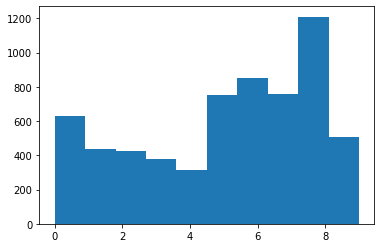

In [ ]:
ans = []
for key in client_mapping:
    ans.extend([key] * len(client_mapping[key]))
plt.hist(ans)

### Using FedChem methods

In [9]:
def gen_hetero_split_scaffold(dataset_name, train_split, num_clients, alpha, min_size):
    if dataset_name == "PCQM4Mv2":
        all_smiles = [x[0] for x in getDataset(dataset_name)]
        smiles_list = all_smiles[:int(train_split*len(all_smiles))]
    else:
        data = getDataset(dataset_name)
        train_data = data[:int(train_split*len(data))]
        smiles_list = train_data[0]

    cluster_idx = scaffold_clustering(smiles_list)
    client_mapping = non_iid_partition_with_dirichlet_distribution(cluster_idx,
                                                                   client_num=num_clients,
                                                                   alpha=alpha, 
                                                                   min_size=min_size)
    
    with open(f"scaffold_{dataset_name}_train_{train_split}_clients_{num_clients}_alpha_{alpha}.json", "w") as f:
        json.dump(client_mapping, f, indent=4)

    return client_mapping

# client_mapping = gen_hetero_split_scaffold(dataset_name="PCQM4Mv2",
#                                            train_split=0.8,
#                                            num_clients=4,
#                                            alpha=0.1,
#                                            min_size=128)
    

(array([ 178.,  314.,  523.,  627.,  627., 1055.,  627.,  627.,  627.,
        1059.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

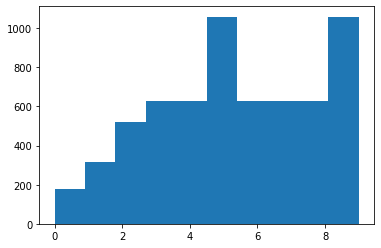

In [ ]:
import matplotlib.pyplot as plt
ans = []
for key in client_mapping:
    ans.extend([key] * len(client_mapping[key]))
plt.hist(ans)

## Comparing datasets

We can also compare the heterogeneity across datasets (or similarly, homogenity within datasets). The standard chemical way to do this is to use molecular fingerprints using a Tanimoto similarity score. 

In [10]:
import rdkit.DataStructs

def stddev_tanimoto_within_dataset(smiles_list, sample_size=None): 
    """
    Returns standard devitaion of average tanimoto similarity for each molecule sample
    """   
    if sample_size:
        sample_smiles = np.random.choice(smiles_list, sample_size)
        fps_list = get_fingerprints(sample_smiles)
    else:
        fps_list = get_fingerprints(smiles_list)

    scores = []
    for fp in fps_list:
        scores.append(sum(rdkit.DataStructs.BulkTanimotoSimilarity(fp, fps_list)) / len(fps_list))
    return np.std(np.asarray(scores))

In [14]:
import json

ALPHA_LIST = [0.1*x for x in range(1,6)]

for dname in ["Lipophilicity"]:
    data = getDataset(dname)
    train_data = data[:int(0.8*len(data))]
    smiles_list = train_data[0]

    for NUM_CLIENTS in [4,8,12,16]:
        for alpha in ALPHA_LIST:
            gen_hetero_split_fps(dataset_name=dname,
                                train_split=0.8,
                                num_clients=NUM_CLIENTS,
                                alpha=alpha,
                                min_size=50)

    for NUM_CLIENTS in [4,8,12,16]:
        for alpha in ALPHA_LIST:
            with open(f"fps_{dname}_train_0.8_clients_{NUM_CLIENTS}_alpha_{alpha}.json") as f:
                mapping = json.load(f)

            var_per_client = []
            smiles_list = np.asarray(smiles_list)
            for key in mapping:
                client_idx = np.asarray(mapping[key])
                smiles_client = smiles_list[client_idx]
                var_per_client.append(stddev_tanimoto_within_dataset(smiles_client))

            print(f"num_client: {NUM_CLIENTS}: alpha: {alpha}: mean_var: {np.mean(var_per_client)}")


Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
num_client: 4: alpha: 0.1: mean_var: 0.019915971392845275
num_client: 4: alpha: 0.2: mean_var: 0.01980347530006086
num_client: 4: alpha: 0.30000000000000004: mean_var: 0.01974656916

In [16]:
ALPHA_LIST = [0.1*x for x in range(1,6)]

for dname in ["Tox21", "Lipophilicity"]:
    data = getDataset(dname)
    train_data = data[:int(0.8*len(data))]
    smiles_list = train_data[0]

    for NUM_CLIENTS in [4,8,12,16]:
        for alpha in ALPHA_LIST:
            gen_hetero_split_scaffold(dataset_name=dname,
                                train_split=0.8,
                                num_clients=NUM_CLIENTS,
                                alpha=alpha,
                                min_size=50)

    for NUM_CLIENTS in [4,8,12,16]:
        for alpha in ALPHA_LIST:
            with open(f"scaffold_{dname}_train_0.8_clients_{NUM_CLIENTS}_alpha_{alpha}.json") as f:
                mapping = json.load(f)

            var_per_client = []
            smiles_list = np.asarray(smiles_list)
            for key in mapping:
                client_idx = np.asarray(mapping[key])
                smiles_client = smiles_list[client_idx]
                var_per_client.append(stddev_tanimoto_within_dataset(smiles_client))

            print(f"num_client: {NUM_CLIENTS}: alpha: {alpha}: mean_var: {np.mean(var_per_client)}")


Loading previously saved dgl graphs...
num_client: 4: alpha: 0.1: mean_var: 0.027482552514471965
num_client: 4: alpha: 0.2: mean_var: 0.02424640475876759
num_client: 4: alpha: 0.30000000000000004: mean_var: 0.025952205231860648
num_client: 4: alpha: 0.4: mean_var: 0.02580361760665493
num_client: 4: alpha: 0.5: mean_var: 0.026492102279128085
num_client: 8: alpha: 0.1: mean_var: 0.02482297261742565
num_client: 8: alpha: 0.2: mean_var: 0.025290081892672667
num_client: 8: alpha: 0.30000000000000004: mean_var: 0.026049835164561434
num_client: 8: alpha: 0.4: mean_var: 0.026057800937989234
num_client: 8: alpha: 0.5: mean_var: 0.02520163141780342
num_client: 12: alpha: 0.1: mean_var: 0.025585883676184307
num_client: 12: alpha: 0.2: mean_var: 0.02463809331229508
num_client: 12: alpha: 0.30000000000000004: mean_var: 0.02657181923942623
num_client: 12: alpha: 0.4: mean_var: 0.02503384176431532
num_client: 12: alpha: 0.5: mean_var: 0.024908909435746574
num_client: 16: alpha: 0.1: mean_var: 0.02483

### tSNE plots

In [20]:
DNAME = "Tox21"
TRAIN_SPLIT = 0.8
NUM_CLIENTS = 15
ALPHA = 0.1
MIN_SIZE = 50

gen_hetero_split_scaffold(dataset_name=DNAME,
                          train_split=TRAIN_SPLIT,
                          num_clients=NUM_CLIENTS,
                          alpha=ALPHA,
                          min_size=MIN_SIZE)

gen_hetero_split_fps(dataset_name=DNAME,
                     train_split=TRAIN_SPLIT,
                     num_clients=NUM_CLIENTS,
                     alpha=ALPHA,
                     min_size=MIN_SIZE)

print("Done!")


Loading previously saved dgl graphs...
Loading previously saved dgl graphs...
Done!


In [18]:
with open(f"fps_{DNAME}_train_{TRAIN_SPLIT}_clients_{NUM_CLIENTS}_alpha_{ALPHA}.json") as f:
    fps_split = json.load(f)

with open(f"scaffold_{DNAME}_train_{TRAIN_SPLIT}_clients_{NUM_CLIENTS}_alpha_{ALPHA}.json") as f:
    scaffold_split = json.load(f)

data = getDataset(DNAME)
train_data = data[:int(TRAIN_SPLIT*len(data))]
smiles_list = train_data[0]
fps_list = get_fingerprints(smiles_list)

def convert_map_to_cluster(mapping):
    num_entries = sum([len(mapping[k]) for k in mapping])
    ans = np.zeros(num_entries)
    for i in mapping:
        ans[np.asarray(mapping[i])] = int(i)
    return ans

Loading previously saved dgl graphs...


In [13]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2,
                     perplexity=200,
                     early_exaggeration=30,
                     learning_rate=200,
                     n_iter=1000,
                     init='pca',
                     n_jobs=-1)
embed = tsne.fit_transform(fps_list)
print("Done!")

Done!


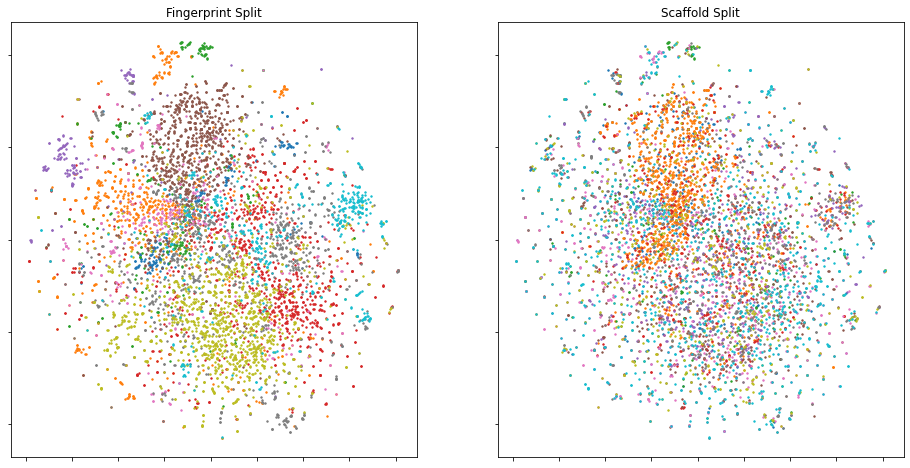

In [21]:
from matplotlib.ticker import NullFormatter

fps_cluster_idx = convert_map_to_cluster(fps_split)
scaf_cluster_idx = convert_map_to_cluster(scaffold_split)

(fig, ax) = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title("Fingerprint Split")
for c_idx in range(NUM_CLIENTS):
    selector = fps_cluster_idx == np.ones_like(fps_cluster_idx) * c_idx
    ax[0].scatter(embed[selector, 0], embed[selector, 1], s=2)
ax[0].xaxis.set_major_formatter(NullFormatter())
ax[0].yaxis.set_major_formatter(NullFormatter())
ax[0].axis("tight")

ax[1].set_title("Scaffold Split")
for c_idx in range(NUM_CLIENTS):
    selector = scaf_cluster_idx == np.ones_like(scaf_cluster_idx) * c_idx
    ax[1].scatter(embed[selector, 0], embed[selector, 1], s=2)
ax[1].xaxis.set_major_formatter(NullFormatter())
ax[1].yaxis.set_major_formatter(NullFormatter())
ax[1].axis("tight")

plt.show()